# **NLU final project - Barba Edoardo**
##Intent Classification and Slot Filling

In [1]:
# Global variables
import os
device = 'cuda:0'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
PAD_TOKEN = 0

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim as optim
import pandas as pd
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

#Data preparation

Function to load dataset

In [4]:
import json
from pprint import pprint

def load_data(path):
    '''
        input: path/to/data
        output: json 
    '''
    dataset = []
    with open(path) as f:
        dataset = json.loads(f.read())
    return dataset

###Load ATIS train and test set

In [5]:
tmp_ATIS_train_raw = load_data(os.path.join('drive', 'MyDrive', 'data','ATIS','train.json'))
ATIS_test_raw = load_data(os.path.join('drive','MyDrive', 'data','ATIS','test.json'))
print('Train samples:', len(tmp_ATIS_train_raw))
print('Test samples:', len(ATIS_test_raw))

Train samples: 4978
Test samples: 893


In [6]:
pprint(tmp_ATIS_train_raw[0])

{'intent': 'flight',
 'slots': 'O O O O O B-fromloc.city_name O B-depart_time.time '
          'I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O '
          'B-arrive_time.period_of_day',
 'utterance': 'i want to fly from boston at 838 am and arrive in denver at '
              '1110 in the morning'}


###Load SNIPS train and test set


In [7]:
tmp_SNIPS_train_raw = load_data(os.path.join('drive', 'MyDrive', 'data','SNIPS','train.json'))
SNIPS_test_raw = load_data(os.path.join('drive','MyDrive', 'data','SNIPS','test.json'))
print('Train samples:', len(tmp_SNIPS_train_raw))
print('Test samples:', len(SNIPS_test_raw))

Train samples: 13084
Test samples: 700


In [8]:
pprint(tmp_SNIPS_train_raw[0])

{'intent': 'PlayMusic',
 'slots': 'O O B-artist O B-album O B-service I-service',
 'utterance': 'listen to westbam alumb allergic on google music'}


###Create validation set

In [9]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

def create_dev(tmp_train_raw, test_raw):

  portion = round(((len(tmp_train_raw) + len(test_raw)) * 0.10)/(len(tmp_train_raw)),2)

  intents = [x['intent'] for x in tmp_train_raw] 

  count_y = Counter(intents) 

  Y = []
  X = []
  mini_Train = []

  for id_y, y in enumerate(intents):
      if count_y[y] > 1: # Some intents have only one instance, we put them in training
          X.append(tmp_train_raw[id_y])
          Y.append(y)
      else:
          mini_Train.append(tmp_train_raw[id_y])
          
  # Random Stratify
  X_train, X_dev, y_train, y_dev = train_test_split(X, Y, test_size=portion, 
                                                      random_state=42, 
                                                      shuffle=True,
                                                      stratify=Y)
  X_train.extend(mini_Train)
  train_raw = X_train
  dev_raw = X_dev

  y_test = [x['intent'] for x in test_raw]




  return train_raw, dev_raw, test_raw, y_train, y_dev, y_test
  #some intents are not present in train set!!!!!!!!!!!

In [10]:
ATIS_train_raw, ATIS_dev_raw, ATIS_test_raw, ATIS_y_train, ATIS_y_dev, ATIS_y_test = create_dev(tmp_ATIS_train_raw, ATIS_test_raw)

In [11]:
SNIPS_train_raw, SNIPS_dev_raw, SNIPS_test_raw, SNIPS_y_train, SNIPS_y_dev, SNIPS_y_test = create_dev(tmp_SNIPS_train_raw, SNIPS_test_raw)

In [12]:
def plot_data_distr(train_raw, dev_raw, test_raw, y_train, y_dev, y_test):
  #Number of labels 
  print("Number of Intent labels: ", len(Counter(y_train + y_test + y_dev)))
  
  # Intent distribution
  print('Train:')
  odict = {k:round(v/len(y_train),3)*100 for k, v in sorted(Counter(y_train).items())}
  plt.barh(list(odict.keys()), odict.values(), align = 'center')
  plt.show()
  #pprint({k:round(v/len(y_train),3)*100 for k, v in sorted(Counter(y_train).items())})
  print('Dev:')
  odict = {k:round(v/len(y_dev),3)*100 for k, v in sorted(Counter(y_dev).items())}
  plt.barh(list(odict.keys()), odict.values(), align = 'center')
  plt.show()
  #pprint({k:round(v/len(y_dev),3)*100 for k, v in sorted(Counter(y_dev).items())})
  print('Test:') 
  odict = {k:round(v/len(y_test),3)*100 for k, v in sorted(Counter(y_test).items())}
  plt.barh(list(odict.keys()), odict.values())
  plt.show()
  #pprint({k:round(v/len(y_test),3)*100 for k, v in sorted(Counter(y_test).items())})
  print('='*89)
  #print("train_raw[0]: ", train_raw[0])

  # Dataset size
  print('TRAIN size:', len(train_raw))
  print('DEV size:', len(dev_raw))
  print('TEST size:', len(test_raw))

###Intent distribution

ATIS

Number of Intent labels:  22
Train:


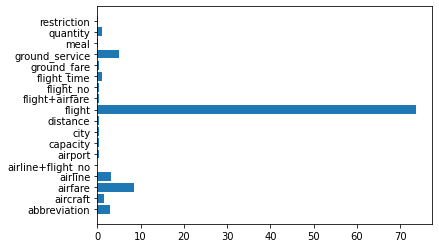

Dev:


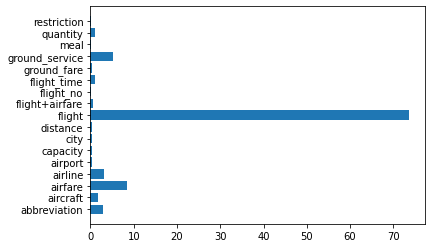

Test:


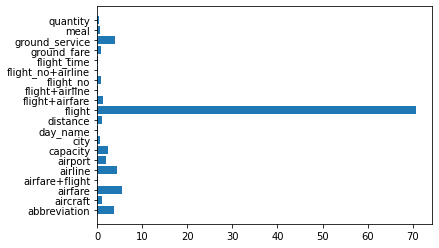

TRAIN size: 4381
DEV size: 597
TEST size: 893


In [13]:
plot_data_distr(ATIS_train_raw, ATIS_dev_raw, ATIS_test_raw, ATIS_y_train, ATIS_y_dev, ATIS_y_test)

SNIPS

Number of Intent labels:  7
Train:


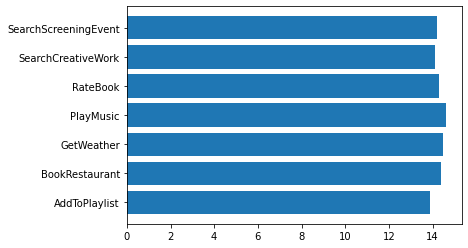

Dev:


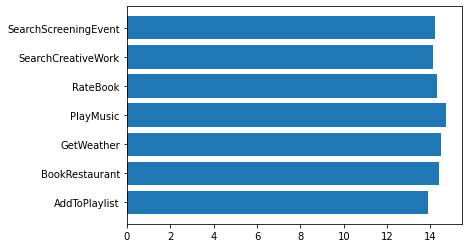

Test:


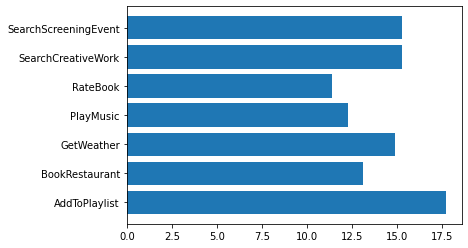

TRAIN size: 11644
DEV size: 1440
TEST size: 700


In [14]:
plot_data_distr(SNIPS_train_raw, SNIPS_dev_raw, SNIPS_test_raw, SNIPS_y_train, SNIPS_y_dev, SNIPS_y_test)

###Slot labels distribution

ATIS

Number of slot labels:  129
Train:


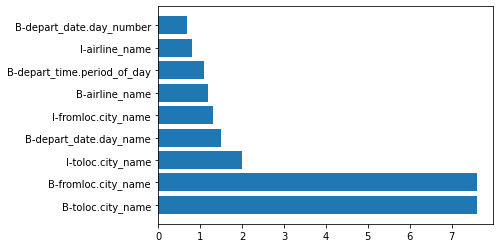

Dev:


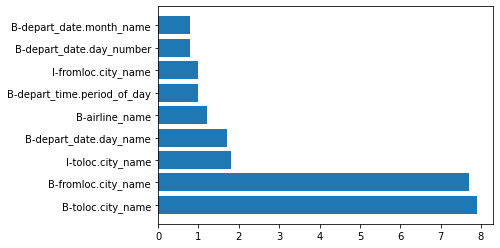

Test:


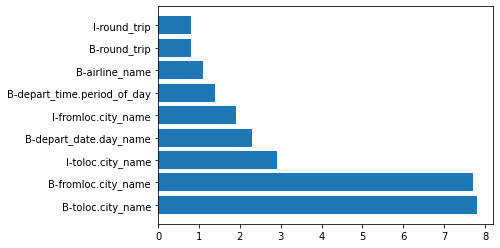

In [15]:
#slot distribution
train_slots = []
for sample in ATIS_train_raw:
  train_slots.extend(sample['slots'].split())

dev_slots = []
for sample in ATIS_dev_raw:
  dev_slots.extend(sample['slots'].split())

test_slots = []
for sample in ATIS_test_raw:
  test_slots.extend(sample['slots'].split())

print("Number of slot labels: ", len(Counter(train_slots + dev_slots + test_slots)))

ordered_train_slots = dict(sorted(Counter(train_slots).items(), key=lambda item: item[1], reverse=True)[:10])
ordered_dev_slots = dict(sorted(Counter(dev_slots).items(), key=lambda item: item[1], reverse=True)[:10])
ordered_test_slots = dict(sorted(Counter(test_slots).items(), key=lambda item: item[1], reverse=True)[:10])

print('Train:')
odict = {k:round(v/len(train_slots),3)*100 for k, v in ordered_train_slots.items()}
odict.pop("O")
plt.barh(list(odict.keys())[:10], list(odict.values())[:10], align = 'center')
plt.show()

print('Dev:')
odict = {k:round(v/len(dev_slots),3)*100 for k, v in ordered_dev_slots.items()}
odict.pop("O")
plt.barh(list(odict.keys())[:10], list(odict.values())[:10], align = 'center')
plt.show()

print('Test:') 
odict = {k:round(v/len(test_slots),3)*100 for k, v in ordered_test_slots.items()}
odict.pop("O")
plt.barh(list(odict.keys())[:10], list(odict.values())[:10], align = 'center')
plt.show()

SNIPS

Number of slot labels:  72
Train:


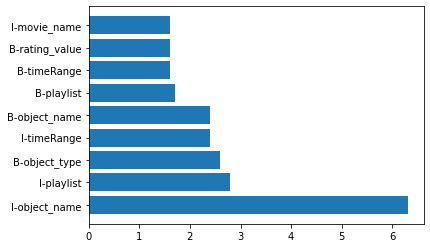

Dev:


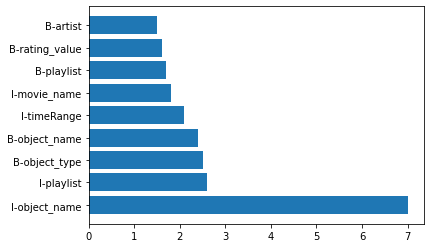

Test:


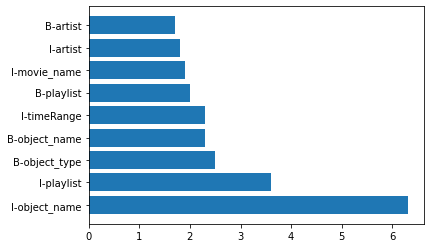

In [16]:
#Number of slot labels: 
#slot distribution
train_slots = []
for sample in SNIPS_train_raw:
  train_slots.extend(sample['slots'].split())

dev_slots = []
for sample in SNIPS_dev_raw:
  dev_slots.extend(sample['slots'].split())

test_slots = []
for sample in SNIPS_test_raw:
  test_slots.extend(sample['slots'].split())

print("Number of slot labels: ", len(Counter(train_slots + dev_slots + test_slots)))

ordered_train_slots = dict(sorted(Counter(train_slots).items(), key=lambda item: item[1], reverse=True)[:10])
ordered_dev_slots = dict(sorted(Counter(dev_slots).items(), key=lambda item: item[1], reverse=True)[:10])
ordered_test_slots = dict(sorted(Counter(test_slots).items(), key=lambda item: item[1], reverse=True)[:10])

print('Train:')
odict = {k:round(v/len(train_slots),3)*100 for k, v in ordered_train_slots.items()}
odict.pop("O")
plt.barh(list(odict.keys())[:10], list(odict.values())[:10], align = 'center')
plt.show()

print('Dev:')
odict = {k:round(v/len(dev_slots),3)*100 for k, v in ordered_dev_slots.items()}
odict.pop("O")
plt.barh(list(odict.keys())[:10], list(odict.values())[:10], align = 'center')
plt.show()

print('Test:') 
odict = {k:round(v/len(test_slots),3)*100 for k, v in ordered_test_slots.items()}
odict.pop("O")
plt.barh(list(odict.keys())[:10], list(odict.values())[:10], align = 'center')
plt.show()

##Lang class

We use it to convert word,intent and slot to id and vice versa

In [17]:
class Lang():
    def __init__(self, words, intents, slots, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}

    #method to transform words to id 
    def w2id(self, elements, cutoff=None, unk=True):
        vocab = {'pad': PAD_TOKEN}
        if unk:
            vocab['unk'] = len(vocab)
        count = Counter(elements)
        for k, v in count.items():
            if v > cutoff:
                #print("k: ", k)
                #print("v: ", v)
                #print("len(vocab): ", len(vocab))
                vocab[k] = len(vocab)
                #print("vocab[k]: ", vocab[k])
        #pprint(vocab)
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
                vocab[elem] = len(vocab)
        return vocab

Create lang object of ATIS and SNIPS datasets

In [18]:
ATIS_words = sum([x['utterance'].split() for x in ATIS_train_raw], []) # No set() since we want to compute 
                                                            # the cutoff
ATIS_corpus = ATIS_train_raw + ATIS_dev_raw + ATIS_test_raw # We do not want unk labels, 
                                        # however this depends on the research purpose
ATIS_slots = set(sum([line['slots'].split() for line in ATIS_corpus],[])) # the type of slots
ATIS_intents = set([line['intent'] for line in ATIS_corpus]) #all the intent types

ATIS_lang = Lang(ATIS_words, ATIS_intents, ATIS_slots, cutoff=0)

In [19]:
SNIPS_words = sum([x['utterance'].split() for x in SNIPS_train_raw], []) # No set() since we want to compute 
                                                            # the cutoff
SNIPS_corpus = SNIPS_train_raw + SNIPS_dev_raw + SNIPS_test_raw # We do not want unk labels, 
                                        # however this depends on the research purpose
SNIPS_slots = set(sum([line['slots'].split() for line in SNIPS_corpus],[])) # the type of slots
SNIPS_intents = set([line['intent'] for line in SNIPS_corpus]) #all the intent types

SNIPS_lang = Lang(SNIPS_words, SNIPS_intents, SNIPS_slots, cutoff=0)

Now we can see how words, intent and slots are mapped into ids

In [101]:
print(list(ATIS_lang.word2id.items())[:5])
print(list(ATIS_lang.intent2id.items())[:5])
print(list(ATIS_lang.slot2id.items())[:5])

[('pad', 0), ('unk', 1), ('what', 2), ('type', 3), ('of', 4)]
[('airfare+flight', 0), ('flight+airline', 1), ('quantity', 2), ('meal', 3), ('capacity', 4)]
[('pad', 0), ('B-booking_class', 1), ('B-meal_code', 2), ('B-aircraft_code', 3), ('B-depart_time.time_relative', 4)]


In [102]:
print(list(SNIPS_lang.word2id.items())[:5])
print(list(SNIPS_lang.intent2id.items())[:5])
print(list(SNIPS_lang.slot2id.items())[:5])

[('pad', 10605), ('unk', 1), ('can', 2), ('i', 3), ('get', 4)]
[('SearchCreativeWork', 0), ('GetWeather', 1), ('RateBook', 2), ('AddToPlaylist', 3), ('PlayMusic', 4)]
[('pad', 0), ('I-country', 1), ('B-cuisine', 2), ('I-object_select', 3), ('B-service', 4)]


### Customize the Dataset class

In [22]:
import torch
import torch.utils.data as data

class IntentsAndSlots(data.Dataset):
    # Mandatory methods are __init__, __len__ and __getitem__
    def __init__(self, dataset, lang, unk='unk'):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.unk = unk
        
        for x in dataset:
            self.utterances.append(x['utterance'])
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])

#convert to numbers
        self.utt_ids = self.mapping_seq(self.utterances, lang.word2id)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        utt = torch.Tensor(self.utt_ids[idx])
        slots = torch.Tensor(self.slot_ids[idx])
        intent = self.intent_ids[idx]
        sample = {'utterance': utt, 'slots': slots, 'intent': intent}
        return sample #dictionary with 3 keys
    
    # Auxiliary methods
    
    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]
    
    def mapping_seq(self, data, mapper): # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res


In [23]:
# Create our ATIS datasets
ATIS_train_dataset = IntentsAndSlots(ATIS_train_raw, ATIS_lang)
ATIS_dev_dataset = IntentsAndSlots(ATIS_dev_raw, ATIS_lang)
ATIS_test_dataset = IntentsAndSlots(ATIS_test_raw, ATIS_lang)

In [24]:
# Create our SNIPS datasets
SNIPS_train_dataset = IntentsAndSlots(SNIPS_train_raw, SNIPS_lang)
SNIPS_dev_dataset = IntentsAndSlots(SNIPS_dev_raw, SNIPS_lang)
SNIPS_test_dataset = IntentsAndSlots(SNIPS_test_raw, SNIPS_lang)

###Dataloader

In [25]:
from torch.utils.data import DataLoader

def collate_fn(data):
    def merge(sequences):
        '''
        merge from batch * sent_len to batch * max_len 
        '''
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        # Pad token is zero in our case
        # So we create a matrix full of PAD_TOKEN (i.e. 0) with the shape 
        # batch_size X maximum length of a sequence
        padded_seqs = torch.LongTensor(len(sequences), max_len).fill_(PAD_TOKEN)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq # We copy each sequence into the matrix
        # print(padded_seqs)
        padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph
        return padded_seqs, lengths
        
    # Sort data by seq lengths
    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    # We just need one length for packed pad seq, since len(utt) == len(slots)
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(device) # We load the Tensor on our seleceted device
    y_slots = y_slots.to(device)
    intent = intent.to(device)
    y_lengths = torch.LongTensor(y_lengths).to(device)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    return new_item

In [26]:
# Dataloader ATIS instantiation
ATIS_train_loader = DataLoader(ATIS_train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
ATIS_dev_loader = DataLoader(ATIS_dev_dataset, batch_size=64, collate_fn=collate_fn)
ATIS_test_loader = DataLoader(ATIS_test_dataset, batch_size=64, collate_fn=collate_fn)

In [27]:
# Dataloader SNIPS instantiation
SNIPS_train_loader = DataLoader(SNIPS_train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
SNIPS_dev_loader = DataLoader(SNIPS_dev_dataset, batch_size=64, collate_fn=collate_fn)
SNIPS_test_loader = DataLoader(SNIPS_test_dataset, batch_size=64, collate_fn=collate_fn)

In [28]:
ATIS_out_slot = len(ATIS_lang.slot2id)
ATIS_out_int = len(ATIS_lang.intent2id)
ATIS_vocab_len = len(ATIS_lang.word2id)
print("ATIS vocabulary len: ", ATIS_vocab_len)

ATIS vocabulary len:  863


In [29]:
SNIPS_out_slot = len(SNIPS_lang.slot2id)
SNIPS_out_int = len(SNIPS_lang.intent2id)
SNIPS_vocab_len = len(SNIPS_lang.word2id)
print("SNIPS vocabulary len: ", SNIPS_vocab_len)

SNIPS vocabulary len:  10621


##Auxiliary methods

In [30]:
def init_weights(mat): #randomly initialize weights
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

In [31]:
def plot_losses(sampled_epochs, loss_train, loss_dev):
  plt.figure(num = 3, figsize=(12, 8)).patch.set_facecolor('white')
  plt.title('Train and Dev Losses')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.plot(sampled_epochs, loss_train, label='Train loss')
  plt.plot(sampled_epochs, loss_dev, label='Dev loss')
  plt.legend()
  plt.show()

#Baseline Model

As baseline model I took the LSTM model seen in class

##Model definition

In [32]:
class ModelIAS(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
        super(ModelIAS, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        #A simple lookup table that stores embeddings of a fixed dictionary and size.
        #The input to the module is a list of indices, and the output is the corresponding word embeddings.
        
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index) #pad idx --> the entities at pad_index do not contribute to the gradient
        
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=False)     #network, unidirectional
        self.slot_out = nn.Linear(hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        self.dropout = nn.Dropout(0.1) #regularization --> randomly mute a neuron, only on training phase. Helps to avoid overfitting
        
    def forward(self, utterance, seq_lengths): #define the architecture
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        #--> get word embedding
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 

        #packed output containing the output features (h_t) from the last layer of the LSTM, 
        #for each t. If a torch.nn.utils.rnn.PackedSequence has been given as the 
        #input, the output will also be a packed sequence.

        #last_hidden containing the final hidden state for each element in the sequence
        #cell containing the final cell state for each element in the sequence
        
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:]
        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, classes 
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

##Train Loop Definition

In [33]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [34]:
from conll import evaluate
from sklearn.metrics import classification_report

def train_loop(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    loss_intent_array = []
    loss_slot_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])

        loss_slot = criterion_slots(slots, sample['y_slots'])

        loss_intent_array.append(loss_intent.item())
        loss_slot_array.append(loss_slot.item())



        loss = loss_intent + loss_slot 

        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        optimizer.step() # Update the weights
    return loss_array, loss_intent_array, loss_slot_array

def eval_loop(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    loss_intent_array = []
    loss_slot_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
   
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 

            loss_intent_array.append(loss_intent.item())
            loss_slot_array.append(loss_slot.item())
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
            
                utterance = [lang.id2word[elem] for elem in utt_ids]
            
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                hyp_slots.append(tmp_seq)
           
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex: #if your model predict slot that are not in ref, it gives error
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    
    return results, report_intent, loss_array, loss_intent_array, loss_slot_array

In [35]:
def train(train_loader, test_loader, dev_loader, model, optimizer, lang, n_epochs=200, patience=5):
  losses_train = []
  loss_intent_train = []
  loss_slot_train = []
  losses_dev = [] 
  loss_intent_dev_array = []
  loss_slot_dev_array= []

  sampled_epochs = []
  best_f1 = 0
  for x in tqdm(range(1,n_epochs)):
      if train:
        loss, loss_intent, loss_slot = train_loop(train_loader, optimizer, criterion_slots, 
                          criterion_intents, model)
        if x % 3 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            loss_intent_train.append(np.asarray(loss_intent).mean())
            loss_slot_train.append(np.asarray(loss_slot).mean())

            results_dev, intent_res, loss_dev, loss_intent_dev, loss_slot_dev = eval_loop(dev_loader, criterion_slots, 
                                                          criterion_intents, model, lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            loss_intent_dev_array.append(np.asarray(loss_intent_dev).mean())
            loss_slot_dev_array.append(np.asarray(loss_slot_dev).mean())
            f1 = results_dev['total']['f']
          
            #print('\nSlot F1: ', results_dev['total']['f'])
            #print('Intent Accuracy:', intent_res['accuracy'])
            
            if f1 > best_f1: #sometimes loss words but f1 increases, we have to look at both and figure out what of the 2 to use to stop the training
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

  results_test, intent_test, _ , _ , _ = eval_loop(test_loader, criterion_slots, 
                                          criterion_intents, model, lang)    
  print('\nSlot F1: ', results_test['total']['f'])
  print('Intent Accuracy:', intent_test['accuracy'])
  return results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array

Some hyperparameters

In [36]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate

Definition of loss for slots and intents

In [37]:
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN) #we want to ignore the padding token
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

##Train on ATIS

In [38]:
ATIS_model = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
ATIS_model.apply(init_weights)
ATIS_optimizer = optim.Adam(ATIS_model.parameters(), lr=lr) #take default parameters, just modify lr

In [39]:
runs = 5
slot_f1s, intent_acc = [], []
ATIS_tot_losses_train, ATIS_tot_losses_dev = [], []
ATIS_tot_losses_intent_train, ATIS_tot_losses_intent_dev = [], []
ATIS_tot_losses_slot_train, ATIS_tot_losses_slot_dev = [], []
ATIS_tot_sampled_epochs = []
ATIS_tot_intent_test = []
ATIS_tot_results_test = []

for x in tqdm(range(0, runs)):
    
    ATIS_model = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
    ATIS_model.apply(init_weights)
    ATIS_optimizer_adv = optim.Adam(ATIS_model.parameters(), lr=lr) #take default parameters, just modify lr
    
    results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array = train(
        train_loader = ATIS_train_loader, 
        test_loader = ATIS_test_loader, 
        dev_loader = ATIS_dev_loader, 
        model = ATIS_model, 
        optimizer = ATIS_optimizer_adv,
        lang = ATIS_lang) 
    
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
    ATIS_tot_losses_train.append(losses_train)
    ATIS_tot_losses_dev.append(losses_dev)
    ATIS_tot_losses_intent_train.append(loss_intent_train)
    ATIS_tot_losses_intent_dev.append(loss_intent_dev_array)
    ATIS_tot_losses_slot_train.append(loss_slot_train)
    ATIS_tot_losses_slot_dev.append(loss_slot_dev_array) 
    ATIS_tot_sampled_epochs.append(sampled_epochs)
    ATIS_tot_intent_test.append(intent_test)
    ATIS_tot_results_test.append(results_test)

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('\nSlot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.9084223428471371
Intent Accuracy: 0.9406494960806271


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.907943187795897
Intent Accuracy: 0.9361702127659575


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.9212376933895922
Intent Accuracy: 0.9384098544232923


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.905251951738822
Intent Accuracy: 0.9361702127659575


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.9044495656798439
Intent Accuracy: 0.9406494960806271

Slot F1 0.909 +- 0.006
Intent Acc 0.938 +- 0.006


###Intent classification analysis 

In [40]:
x = ATIS_tot_intent_test[0]
print("Accuracy: ", x.pop('accuracy'))

Accuracy:  0.9406494960806271


Macro average and weighted average

In [41]:
avg = {'weighted avg': x['weighted avg'], 'macro avg' :  x['macro avg']}
x.pop('macro avg')
x.pop('weighted avg')
table = pd.DataFrame.from_dict(avg).transpose()
table.round(decimals=3)

,precision,recall,f1-score,support
weighted avg,0.929,0.941,0.927,893.0
macro avg,0.626,0.569,0.563,893.0


10 best classified intent labels (based on F1-score):

In [42]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:10]
table.round(decimals=3)

,precision,recall,f1-score,support
abbreviation,1.000,1.000,1.000,33.0
flight_time,1.000,1.000,1.000,1.0
flight,0.960,0.989,0.974,632.0
ground_service,0.947,1.000,0.973,36.0
airline,0.905,1.000,0.950,38.0
distance,1.000,0.900,0.947,10.0
airport,1.000,0.889,0.941,18.0
capacity,1.000,0.857,0.923,21.0
airfare,0.825,0.979,0.895,48.0
ground_fare,1.000,0.714,0.833,7.0


10 worst classified intent labels (based on F1-score):

In [43]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:10]
table.round(decimals=3)

,precision,recall,f1-score,support
airfare+flight,0.000,0.000,0.000,1.0
day_name,0.000,0.000,0.000,2.0
flight+airline,0.000,0.000,0.000,1.0
flight_no+airline,0.000,0.000,0.000,1.0
meal,0.000,0.000,0.000,6.0
flight+airfare,1.000,0.083,0.154,12.0
flight_no,0.250,0.125,0.167,8.0
city,0.500,0.167,0.250,6.0
quantity,0.375,1.000,0.545,3.0
aircraft,0.750,0.667,0.706,9.0


###Slot filling analysis

In [44]:
x = ATIS_tot_results_test[0]

15 best slot labels

In [45]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:15]
table.round(decimals=3)

,p,r,f,s
fromloc.state_code,1.000,1.000,1.000,23.0
flight_stop,1.000,1.000,1.000,21.0
flight_days,1.000,1.000,1.000,10.0
flight_time,1.000,1.000,1.000,1.0
toloc.country_name,1.000,1.000,1.000,1.0
toloc.state_code,1.000,1.000,1.000,18.0
connect,1.000,1.000,1.000,6.0
state_code,1.000,1.000,1.000,1.0
economy,1.000,1.000,1.000,6.0
round_trip,0.986,0.973,0.979,73.0


15 worst slot labels

In [46]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:15]
table.round(decimals=3)

,p,r,f,s
state_name,1.000,0.00,0.00,9.0
meal_code,1.000,0.00,0.00,1.0
airport_code,0.000,0.00,0.00,9.0
return_date.day_name,1.000,0.00,0.00,2.0
depart_time.end_time,0.000,0.00,0.00,3.0
fare_amount,0.000,0.00,0.00,2.0
days_code,1.000,0.00,0.00,1.0
mod,0.000,0.00,0.00,2.0
stoploc.airport_code,1.000,0.00,0.00,1.0
booking_class,1.000,0.00,0.00,1.0


###Losses plots 

Total loss plot

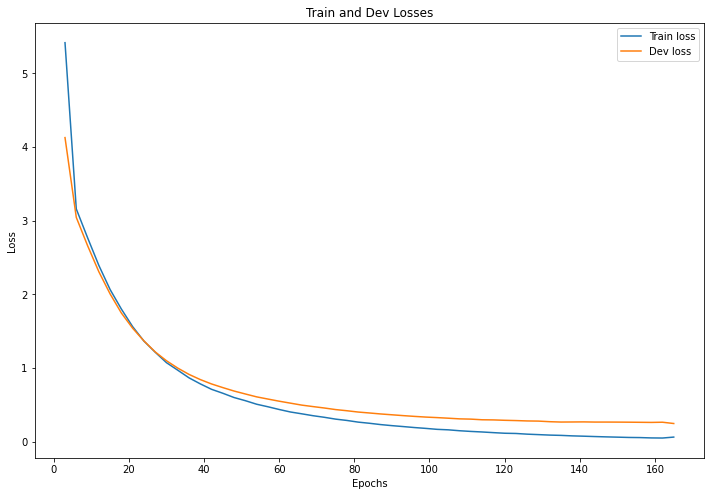

In [47]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_train[0], ATIS_tot_losses_dev[0])

Intent loss plot

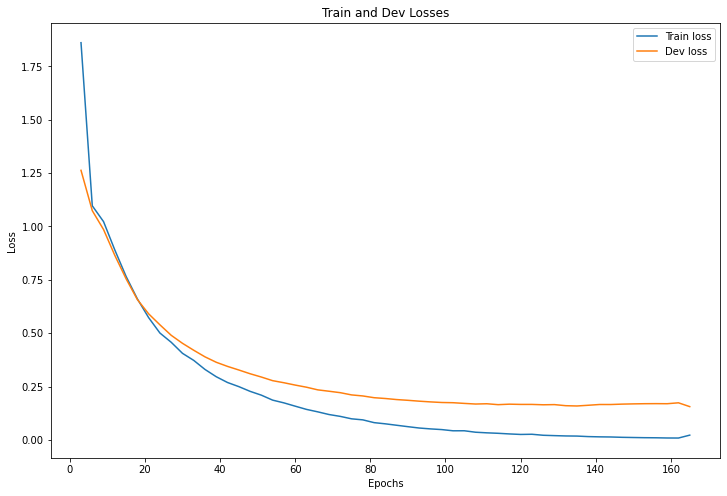

In [48]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_intent_train[0], ATIS_tot_losses_intent_dev[0])

Slot loss plot

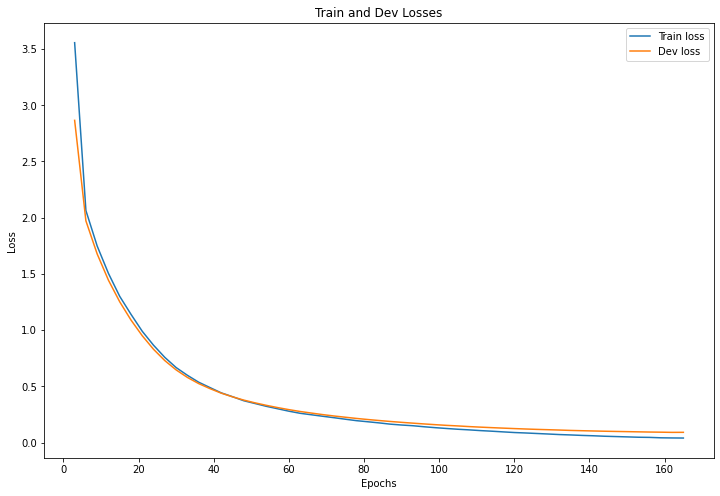

In [49]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_slot_train[0], ATIS_tot_losses_slot_dev[0])

##Train on SNIPS

In [50]:
runs = 5
slot_f1s, intent_acc = [], []
SNIPS_tot_losses_train, SNIPS_tot_losses_dev = [], []
SNIPS_tot_losses_intent_train, SNIPS_tot_losses_intent_dev = [], []
SNIPS_tot_losses_slot_train, SNIPS_tot_losses_slot_dev = [], []
SNIPS_tot_sampled_epochs = []
SNIPS_tot_intent_test = []
SNIPS_tot_results_test = []
 
for x in tqdm(range(0, runs)):
    
    SNIPS_model_adv = ModelIAS(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
    SNIPS_model_adv.apply(init_weights)
    SNIPS_optimizer_adv = optim.Adam(SNIPS_model_adv.parameters(), lr=lr) #take default parameters, just modify lr
    
    results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array = train(
        train_loader = SNIPS_train_loader, 
        test_loader = SNIPS_test_loader, 
        dev_loader = SNIPS_dev_loader, 
        model = SNIPS_model_adv, 
        optimizer = SNIPS_optimizer_adv,
        lang = SNIPS_lang) 
    
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
    SNIPS_tot_losses_train.append(losses_train)
    SNIPS_tot_losses_dev.append(losses_dev)
    SNIPS_tot_losses_intent_train.append(loss_intent_train)
    SNIPS_tot_losses_intent_dev.append(loss_intent_dev_array)
    SNIPS_tot_losses_slot_train.append(loss_slot_train)
    SNIPS_tot_losses_slot_dev.append(loss_slot_dev_array) 
    SNIPS_tot_sampled_epochs.append(sampled_epochs)
    SNIPS_tot_intent_test.append(intent_test)
    SNIPS_tot_results_test.append(results_test)
 
slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('\nSlot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.7973154362416108
Intent Accuracy: 0.9585714285714285


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.7933884297520661
Intent Accuracy: 0.9542857142857143


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.7928552386030392
Intent Accuracy: 0.96


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.784729586426299
Intent Accuracy: 0.9557142857142857


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.7865466101694915
Intent Accuracy: 0.9557142857142857

Slot F1 0.791 +- 0.005
Intent Acc 0.957 +- 0.005


###Intent classification analysis 

In [51]:
x = SNIPS_tot_intent_test[0]
x.pop('accuracy')

0.9585714285714285

Macro average and weighted average

In [52]:
avg = {'weighted avg': x['weighted avg'], 'macro avg' :  x['macro avg']}
x.pop('macro avg')
x.pop('weighted avg')
table = pd.DataFrame.from_dict(avg).transpose()
table.round(decimals=3)

,precision,recall,f1-score,support
weighted avg,0.959,0.959,0.959,700.0
macro avg,0.959,0.959,0.959,700.0


Classified intent labels (based on F1-score):

In [53]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()
table.round(decimals=3)

,precision,recall,f1-score,support
RateBook,0.988,1.000,0.994,80.0
AddToPlaylist,0.984,0.992,0.988,124.0
BookRestaurant,0.978,0.978,0.978,92.0
GetWeather,0.962,0.981,0.971,104.0
SearchScreeningEvent,0.980,0.897,0.937,107.0
PlayMusic,0.920,0.942,0.931,86.0
SearchCreativeWork,0.900,0.925,0.912,107.0


###Slot filling analysis

In [54]:
x = SNIPS_tot_results_test[0]

15 best classified slot labels

In [55]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:15]
table.round(decimals=3)

,p,r,f,s
best_rating,1.000,1.000,1.000,43.0
movie_type,1.000,1.000,1.000,33.0
facility,1.000,1.000,1.000,3.0
rating_unit,1.000,1.000,1.000,40.0
rating_value,0.987,0.975,0.981,80.0
year,0.960,1.000,0.980,24.0
condition_temperature,1.000,0.957,0.978,23.0
music_item,0.963,0.990,0.976,104.0
condition_description,1.000,0.929,0.963,28.0
current_location,1.000,0.929,0.963,14.0


15 worst classified slot labels

In [56]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:15]
table.round(decimals=3)

,p,r,f,s
geographic_poi,0.053,0.091,0.067,11.0
track,0.091,0.111,0.100,9.0
album,0.091,0.200,0.125,10.0
entity_name,0.313,0.636,0.420,33.0
poi,0.455,0.625,0.526,8.0
restaurant_name,0.455,0.667,0.541,15.0
movie_name,0.519,0.574,0.545,47.0
object_name,0.517,0.619,0.563,147.0
cuisine,0.857,0.429,0.571,14.0
artist,0.731,0.533,0.616,107.0


###Losses plots

Total loss plot

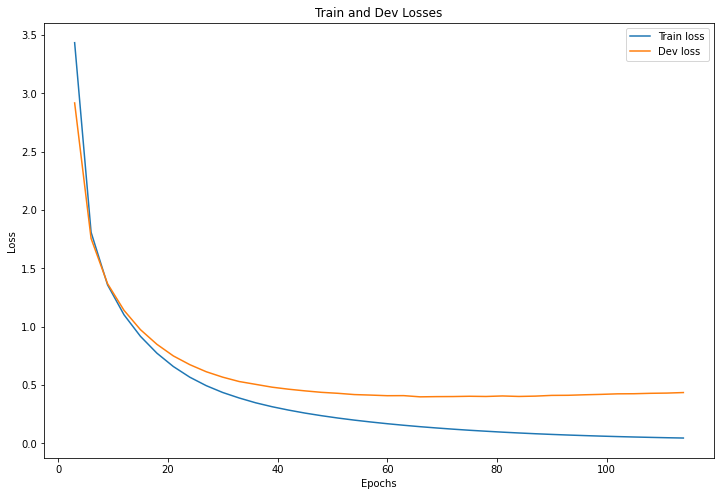

In [57]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_train[0], SNIPS_tot_losses_dev[0])

Intent loss plot

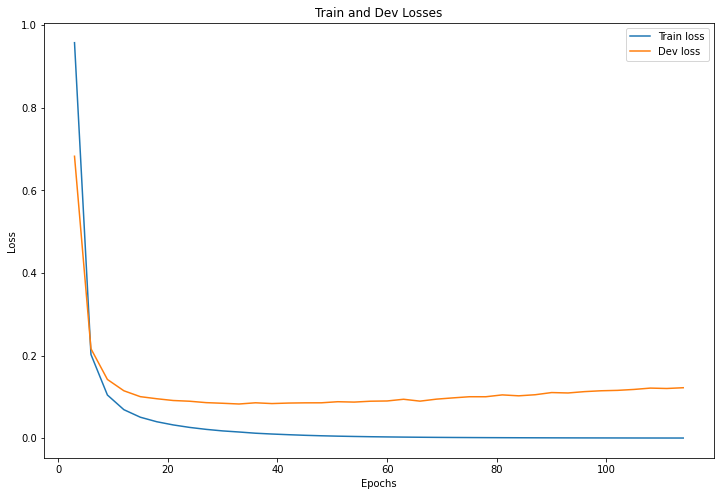

In [58]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_intent_train[0], SNIPS_tot_losses_intent_dev[0])

Slot loss plot

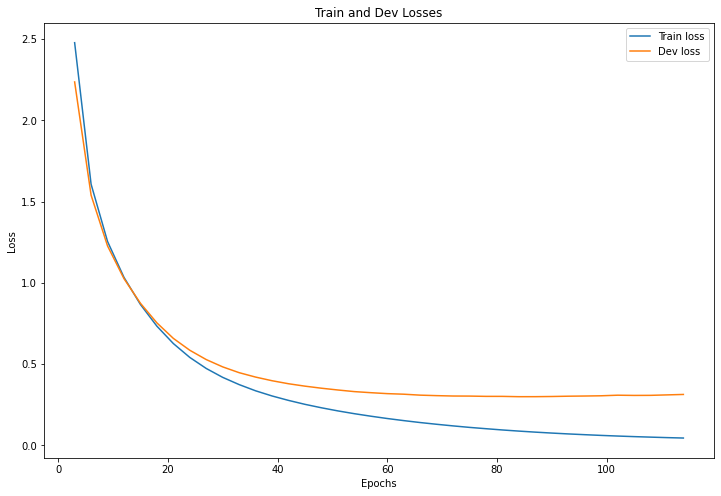

In [59]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_slot_train[0], SNIPS_tot_losses_slot_dev[0])

#Second model: Bi-LSMT Model

In [60]:
class Model_adv(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=2, pad_index=0):
        super(Model_adv, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        #A simple lookup table that stores embeddings of a fixed dictionary and size.
        #The input to the module is a list of indices, and the output is the corresponding word embeddings.
        
        self.embedding = nn.Embedding(vocab_len, 
                                      emb_size, 
                                      padding_idx=pad_index) #pad idx --> the entities at pad_index do not contribute to the gradient
        
        """
        num_embeddings (int) – size of the dictionary of embeddings

        embedding_dim (int) – the size of each embedding vector

        padding_idx (int, optional) – If specified, the entries at padding_idx do not contribute to the gradient; 
      
        """
        self.utt_encoder = nn.LSTM(emb_size, 
                                   hid_size, 
                                   n_layer,
                                   dropout=0.1,
                                   bidirectional=True)     #network, bidirectional

        """  
        input_size – The number of expected features in the input x
        hidden_size – The number of features in the hidden state h
        num_layers – Number of recurrent layers. 
        """
        #regularization --> randomly mute a neuron, only on training phase. Helps to avoid overfitting
        self.dropout = nn.Dropout(0.6)

        self.slot_out = nn.Linear(hid_size*2, out_slot)

        self.intent_out = nn.Linear(hid_size, out_int)
      
        
    def forward(self, utterance, seq_lengths): #define the architecture
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size

        #--> get word embedding
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost

        utt_emb_drop = self.dropout(utt_emb)
        
        packed_input = pack_padded_sequence(utt_emb_drop, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 
        
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        #utt_encoded.shape: [sentence lenght, 128, 200] 

        # Get the last hidden state
        #last_hidde.shape: [1, 128, 200]
        #last_hidde.shape: [128, 200] -> [batch size, hidden_size]

        hidden_conv = last_hidden

        hidden_conv = hidden_conv[-1,:,:]

        drop_utt = self.dropout(utt_encoded)
        drop_hidden = self.dropout(hidden_conv)
       
        # Compute slot logits, i use the encoded representation of the utterance, with the encoding of each word
        slots = self.slot_out(drop_utt)

        intent = self.intent_out(drop_hidden)
       
        slots = slots.permute(1,2,0) # We need this for computing the loss

        return slots, intent

##Train Methods

Train loops that outputs also the intent and slot losses

In [61]:
from conll import evaluate
from sklearn.metrics import classification_report

def train_loop_adv(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    loss_intent_array = []
    loss_slot_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])

        loss_slot = criterion_slots(slots, sample['y_slots'])

        loss_intent_array.append(loss_intent.item())
        loss_slot_array.append(loss_slot.item())

        if random.random() > 0.8:
          alfa = random.random()
        else: 
          alfa = 0.3

        loss = alfa*loss_intent + (1-alfa)*loss_slot 

        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        optimizer.step() # Update the weights
    return loss_array, loss_intent_array, loss_slot_array

def eval_loop_adv(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    loss_intent_array = []
    loss_slot_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 

            loss_intent_array.append(loss_intent.item())
            loss_slot_array.append(loss_slot.item())
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                hyp_slots.append(tmp_seq)
                #print(hyp_slots)
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex: #if your model predict slot that are not in ref, it gives error
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    
    return results, report_intent, loss_array, loss_intent_array, loss_slot_array


In [62]:
def train_adv(train_loader, test_loader, dev_loader, model, criterion_slots, criterion_intents, optimizer, lang, n_epochs=200, patience=3, train=True):
 
  losses_train = []
  loss_intent_train = []
  loss_slot_train = []
  losses_dev = [] 
  loss_intent_dev_array = []
  loss_slot_dev_array= []

  sampled_epochs = []
  best_f1 = 0
  last_loss = 0
  for x in tqdm(range(1,n_epochs)):
      if train:
        loss, loss_intent, loss_slot = train_loop_adv(train_loader, optimizer, criterion_slots, 
                          criterion_intents, model)
        if x % 3 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            loss_intent_train.append(np.asarray(loss_intent).mean())
            loss_slot_train.append(np.asarray(loss_slot).mean())

            results_dev, intent_res, loss_dev, loss_intent_dev, loss_slot_dev = eval_loop_adv(dev_loader, criterion_slots, 
                                                          criterion_intents, model, lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            loss_intent_dev_array.append(np.asarray(loss_intent_dev).mean())
            loss_slot_dev_array.append(np.asarray(loss_slot_dev).mean())
            f1 = results_dev['total']['f']
            accuracy = intent_res['accuracy']
            #print('\nSlot F1: ', results_dev['total']['f'])
            #print('Intent Accuracy:', intent_res['accuracy'])
            

            if f1 > best_f1: #sometimes loss words but f1 increases, we have to look at both and figure out what of the 2 to use to stop the training
                best_f1 = f1
            else:
                patience -= 1

            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

  results_test, intent_test, _ , _ , _ = eval_loop_adv(test_loader, criterion_slots, 
                                          criterion_intents, model, lang)    
  print('\nSlot F1: ', results_test['total']['f'])
  print('Intent Accuracy:', intent_test['accuracy'])
  return results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array

Some hyperparameters

In [63]:
emb_size = 400
hid_size = 400

lr = 0.0001

Losses definition

In [64]:
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN) #we want to ignore the padding token
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

##Train on ATIS 

In [65]:
runs = 5
slot_f1s, intent_acc = [], []
ATIS_tot_losses_train, ATIS_tot_losses_dev = [], []
ATIS_tot_losses_intent_train, ATIS_tot_losses_intent_dev = [], []
ATIS_tot_losses_slot_train, ATIS_tot_losses_slot_dev = [], []
ATIS_tot_sampled_epochs = []
ATIS_tot_intent_test = []
ATIS_tot_results_test = []

for x in tqdm(range(0, runs)):
    
    ATIS_model_adv = Model_adv(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
    ATIS_model_adv.apply(init_weights)
    ATIS_optimizer_adv = optim.Adam(ATIS_model_adv.parameters(), lr=lr) #take default parameters, just modify lr
    
    results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array = train_adv(
        train_loader = ATIS_train_loader, 
        test_loader = ATIS_test_loader, 
        dev_loader = ATIS_dev_loader, 
        model = ATIS_model_adv, 
        criterion_slots = criterion_slots,
        criterion_intents = criterion_intents,
        optimizer = ATIS_optimizer_adv,
        lang = ATIS_lang,
        patience=5) 
    
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
    ATIS_tot_losses_train.append(losses_train)
    ATIS_tot_losses_dev.append(losses_dev)
    ATIS_tot_losses_intent_train.append(loss_intent_train)
    ATIS_tot_losses_intent_dev.append(loss_intent_dev_array)
    ATIS_tot_losses_slot_train.append(loss_slot_train)
    ATIS_tot_losses_slot_dev.append(loss_slot_dev_array) 
    ATIS_tot_sampled_epochs.append(sampled_epochs)
    ATIS_tot_intent_test.append(intent_test)
    ATIS_tot_results_test.append(results_test)

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('\nSlot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.9355524079320113
Intent Accuracy: 0.9641657334826428


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.9362226920366457
Intent Accuracy: 0.9630459126539753


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.925801310430317
Intent Accuracy: 0.9496080627099664


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.9304378531073446
Intent Accuracy: 0.9630459126539753


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.9370037056643727
Intent Accuracy: 0.9585666293393057

Slot F1 0.933 +- 0.004
Intent Acc 0.96 +- 0.004


###Intent classification analysis 

Accuracy

In [66]:
x = ATIS_tot_intent_test[0]
x.pop('accuracy')

0.9641657334826428

Macro average and weighted average

In [67]:
avg = {'weighted avg': x['weighted avg'], 'macro avg' :  x['macro avg']}
x.pop('macro avg')
x.pop('weighted avg')
table = pd.DataFrame.from_dict(avg).transpose()
table.round(decimals=3)

,precision,recall,f1-score,support
weighted avg,0.960,0.964,0.960,893.0
macro avg,0.697,0.690,0.675,893.0


10 best classified intent labels (based on F1-score):

In [68]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:10]
table.round(decimals=3)

,precision,recall,f1-score,support
abbreviation,1.000,1.000,1.000,33.0
distance,1.000,1.000,1.000,10.0
ground_service,1.000,1.000,1.000,36.0
flight,0.975,0.989,0.982,632.0
airline,0.927,1.000,0.962,38.0
airfare,0.940,0.979,0.959,48.0
capacity,0.952,0.952,0.952,21.0
aircraft,1.000,0.889,0.941,9.0
airport,1.000,0.889,0.941,18.0
flight_no,0.889,1.000,0.941,8.0


10 worst classified intent labels (based on F1-score):

In [69]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:10]
table.round(decimals=3)

,precision,recall,f1-score,support
airfare+flight,0.000,0.000,0.000,1.0
day_name,0.000,0.000,0.000,2.0
flight+airline,0.000,0.000,0.000,1.0
flight_no+airline,0.000,0.000,0.000,1.0
city,0.500,0.333,0.400,6.0
flight+airfare,0.833,0.417,0.556,12.0
quantity,0.429,1.000,0.600,3.0
flight_time,0.500,1.000,0.667,1.0
meal,1.000,0.500,0.667,6.0
ground_fare,1.000,0.857,0.923,7.0


###Slot filling analysis

In [70]:
x = ATIS_tot_results_test[0]

15 best classified slot labels

In [71]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:15]
table.round(decimals=3)

,p,r,f,s
stoploc.city_name,1.0,1.0,1.0,20.0
depart_time.end_time,1.0,1.0,1.0,3.0
depart_time.start_time,1.0,1.0,1.0,3.0
fare_amount,1.0,1.0,1.0,2.0
fromloc.state_code,1.0,1.0,1.0,23.0
arrive_time.start_time,1.0,1.0,1.0,8.0
flight_stop,1.0,1.0,1.0,21.0
flight_days,1.0,1.0,1.0,10.0
class_type,1.0,1.0,1.0,24.0
restriction_code,1.0,1.0,1.0,4.0


15 worst classified slot labels

In [72]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:15]
table.round(decimals=3)

,p,r,f,s
state_name,1.000,0.000,0.000,9.0
meal_code,1.000,0.000,0.000,1.0
return_date.day_name,1.000,0.000,0.000,2.0
days_code,1.000,0.000,0.000,1.0
mod,0.000,0.000,0.000,2.0
stoploc.airport_code,1.000,0.000,0.000,1.0
booking_class,1.000,0.000,0.000,1.0
toloc.country_name,1.000,0.000,0.000,1.0
flight,1.000,0.000,0.000,1.0
depart_date.year,1.000,0.000,0.000,3.0


###Losses Plots 

Total loss plot

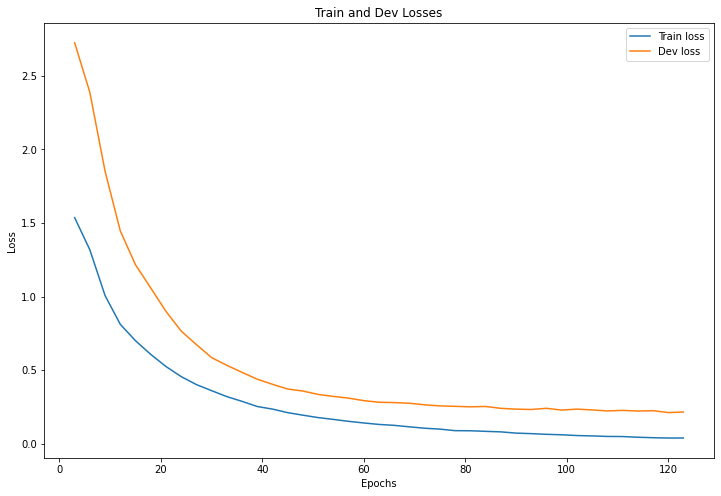

In [73]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_train[0], ATIS_tot_losses_dev[0])

Intent loss plot 

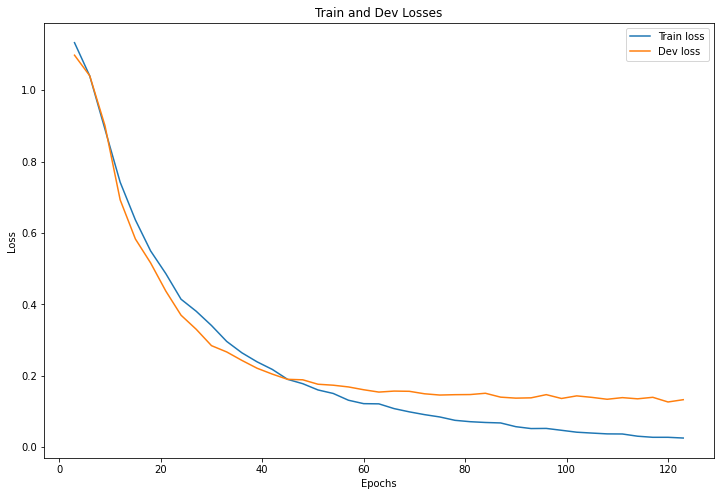

In [74]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_intent_train[0], ATIS_tot_losses_intent_dev[0])

Slot loss plot

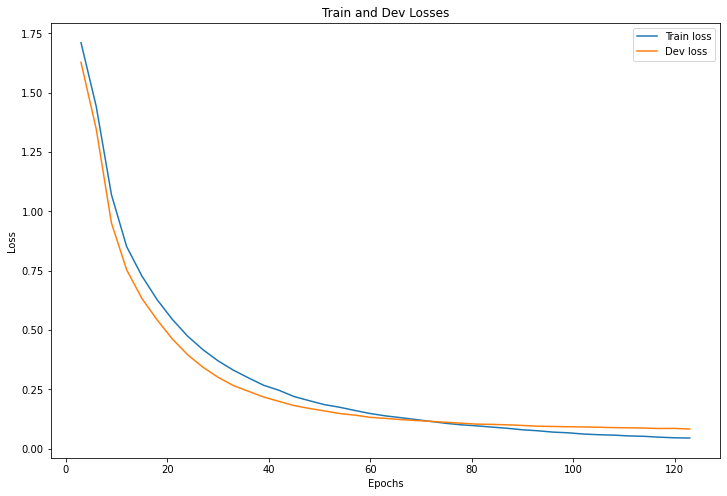

In [75]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_slot_train[0], ATIS_tot_losses_slot_dev[0])

##Train on SNIPS

In [81]:
runs = 5
slot_f1s, intent_acc = [], []
SNIPS_tot_losses_train, SNIPS_tot_losses_dev = [], []
SNIPS_tot_losses_intent_train, SNIPS_tot_losses_intent_dev = [], []
SNIPS_tot_losses_slot_train, SNIPS_tot_losses_slot_dev = [], []
SNIPS_tot_sampled_epochs = []
SNIPS_tot_intent_test = []
SNIPS_tot_results_test = []
 
 
for x in tqdm(range(0, runs)):

    SNIPS_model_adv = Model_adv(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
    SNIPS_model_adv.apply(init_weights)
    SNIPS_optimizer_adv = optim.Adam(SNIPS_model_adv.parameters(), lr=lr) #take default parameters, just modify lr
    
    results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array = train_adv(
        train_loader = SNIPS_train_loader, 
        test_loader = SNIPS_test_loader, 
        dev_loader = SNIPS_dev_loader, 
        model = SNIPS_model_adv, 
        criterion_slots = criterion_slots,
        criterion_intents = criterion_intents,
        optimizer = SNIPS_optimizer_adv,
        lang = SNIPS_lang,
        patience=5)
    
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
    SNIPS_tot_losses_train.append(losses_train)
    SNIPS_tot_losses_dev.append(losses_dev)
    SNIPS_tot_losses_intent_train.append(loss_intent_train)
    SNIPS_tot_losses_intent_dev.append(loss_intent_dev_array)
    SNIPS_tot_losses_slot_train.append(loss_slot_train)
    SNIPS_tot_losses_slot_dev.append(loss_slot_dev_array) 
    SNIPS_tot_sampled_epochs.append(sampled_epochs)
    SNIPS_tot_intent_test.append(intent_test)
    SNIPS_tot_results_test.append(results_test)
 
slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('\nSlot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.8766144545204726
Intent Accuracy: 0.9757142857142858


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.868969298245614
Intent Accuracy: 0.9714285714285714


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.8874244920373421
Intent Accuracy: 0.9714285714285714


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.8861386138613861
Intent Accuracy: 0.9728571428571429


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.8776464118779213
Intent Accuracy: 0.9814285714285714

Slot F1 0.879 +- 0.007
Intent Acc 0.975 +- 0.007


###Intent classification analysis 

In [82]:
x = SNIPS_tot_intent_test[0]
x.pop('accuracy')

0.9757142857142858

Macro average and weighted average

In [83]:
avg = {'weighted avg': x['weighted avg'], 'macro avg' :  x['macro avg']}
x.pop('macro avg')
x.pop('weighted avg')
table = pd.DataFrame.from_dict(avg).transpose()
table.round(decimals=3)

,precision,recall,f1-score,support
weighted avg,0.976,0.976,0.976,700.0
macro avg,0.976,0.976,0.976,700.0


classified intent labels (based on F1-score):

In [84]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()
table.round(decimals=3)

,precision,recall,f1-score,support
BookRestaurant,0.989,1.000,0.995,92.0
RateBook,1.000,0.988,0.994,80.0
AddToPlaylist,0.992,0.992,0.992,124.0
GetWeather,0.990,0.990,0.990,104.0
SearchScreeningEvent,0.990,0.935,0.962,107.0
PlayMusic,0.954,0.965,0.960,86.0
SearchCreativeWork,0.920,0.963,0.941,107.0


###Slot filling analysis

In [85]:
x = SNIPS_tot_results_test[0]

15 best classified slots

In [86]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:15]
table.round(decimals=3)

,p,r,f,s
best_rating,1.000,1.000,1.000,43.0
playlist_owner,1.000,1.000,1.000,70.0
condition_description,1.000,1.000,1.000,28.0
rating_value,1.000,1.000,1.000,80.0
movie_type,1.000,1.000,1.000,33.0
object_location_type,1.000,1.000,1.000,22.0
condition_temperature,1.000,1.000,1.000,23.0
rating_unit,1.000,1.000,1.000,40.0
object_select,0.976,1.000,0.988,40.0
location_name,0.960,1.000,0.980,24.0


15 worst classified slot labels

In [87]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:15]
table.round(decimals=3)

,p,r,f,s
track,0.182,0.222,0.200,9.0
album,0.429,0.600,0.500,10.0
entity_name,0.548,0.515,0.531,33.0
restaurant_name,0.600,0.600,0.600,15.0
country,0.727,0.545,0.623,44.0
cuisine,0.800,0.571,0.667,14.0
served_dish,0.643,0.750,0.692,12.0
city,0.689,0.700,0.694,60.0
party_size_description,0.615,0.800,0.696,10.0
object_name,0.669,0.728,0.697,147.0


###Losses Plots

Total loss plot 

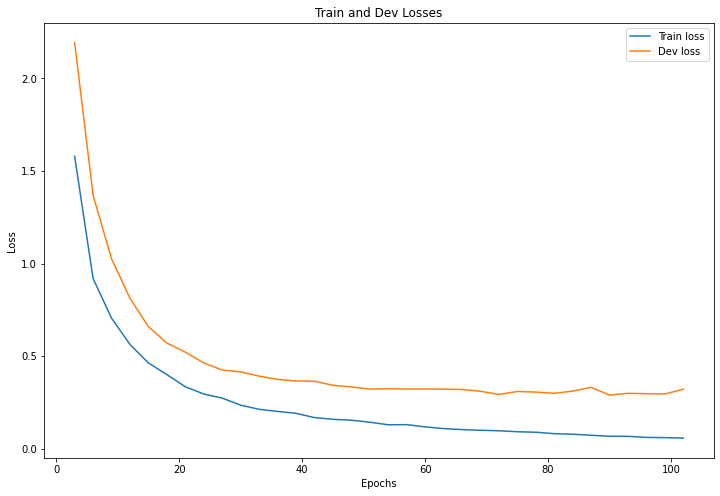

In [88]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_train[0], SNIPS_tot_losses_dev[0])

Intent loss plot 

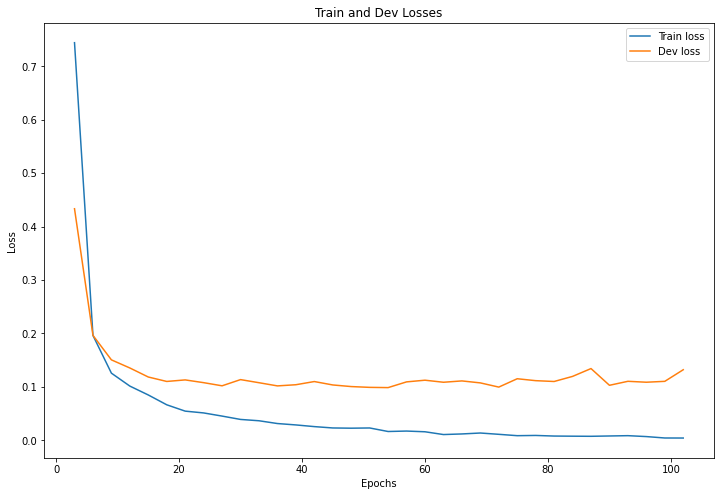

In [89]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_intent_train[0], SNIPS_tot_losses_intent_dev[0])

Slot loss plot 

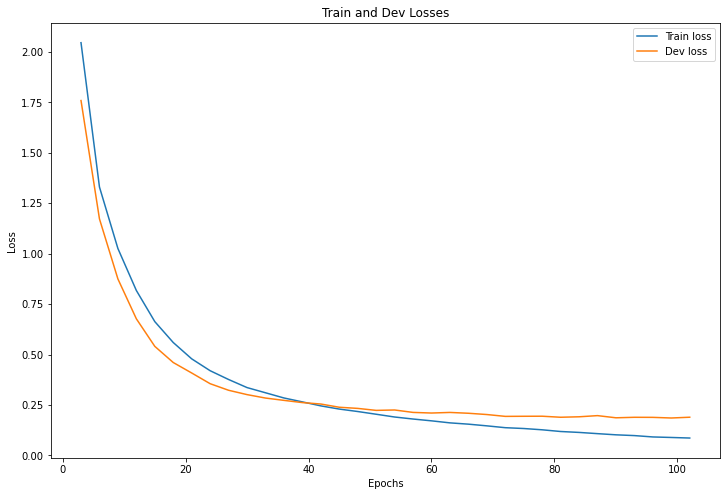

In [90]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_slot_train[0], SNIPS_tot_losses_slot_dev[0])

#Third model: BERT Model

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# BERT model script from: huggingface.co
from transformers import BertModel, BertConfig

In [ ]:
class Bert_model(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, pad_index=0):
        super(Bert_model, self).__init__()
        
        self.embedding = nn.Embedding(vocab_len, 
                                      emb_size, 
                                      padding_idx=pad_index) #pad idx --> the entities at pad_index do not contribute to the gradient

        config = BertConfig()
        
        self.bert = BertModel.from_pretrained("bert-base-uncased", config = config, ignore_mismatched_sizes=True)

        self.dropout = nn.Dropout(0.6)

        self.slot_out = nn.Linear(768, out_slot)

        self.intent_out = nn.Linear(768, out_int)
      
        
    def forward(self, utterance, seq_lengths): 

        #utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size

        #utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
           
        output = self.bert(utterance) 

        hidden_slot = output.last_hidden_state
        hidden_slot = hidden_slot.permute(1,0,2) 

        utt_encoded = output.pooler_output

        drop_utt = self.dropout(utt_encoded)
        drop_hidden = self.dropout(hidden_slot)

        slots = self.slot_out(drop_hidden)

        intent = self.intent_out(drop_utt)

        slots = slots.permute(1,2,0) # We need this for computing the loss

        return slots, intent

##Train on ATIS

In [ ]:
runs = 1
slot_f1s, intent_acc = [], []
ATIS_tot_losses_train, ATIS_tot_losses_dev = [], []
ATIS_tot_losses_intent_train, ATIS_tot_losses_intent_dev = [], []
ATIS_tot_losses_slot_train, ATIS_tot_losses_slot_dev = [], []
ATIS_tot_sampled_epochs = []
ATIS_tot_intent_test = []
ATIS_tot_results_test = []
 
for x in tqdm(range(0, runs)):
    
    ATIS_model_bert = Bert_model(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
    ATIS_optimizer_bert = optim.Adam(ATIS_model_bert.parameters(), lr=lr) #take default parameters, just modify lr
    
    results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array = train_adv(
        train_loader = ATIS_train_loader, 
        test_loader = ATIS_test_loader, 
        dev_loader = ATIS_dev_loader, 
        model = ATIS_model_bert, 
        criterion_slots = criterion_slots,
        criterion_intents = criterion_intents,
        optimizer = ATIS_optimizer_bert,
        lang = ATIS_lang,
        patience=5)
    
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
    ATIS_tot_losses_train.append(losses_train)
    ATIS_tot_losses_dev.append(losses_dev)
    ATIS_tot_losses_intent_train.append(loss_intent_train)
    ATIS_tot_losses_intent_dev.append(loss_intent_dev_array)
    ATIS_tot_losses_slot_train.append(loss_slot_train)
    ATIS_tot_losses_slot_dev.append(loss_slot_dev_array) 
    ATIS_tot_sampled_epochs.append(sampled_epochs)
    ATIS_tot_intent_test.append(intent_test)
    ATIS_tot_results_test.append(results_test)

 
slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('\nSlot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.9276431331225853
Intent Accuracy: 0.9529675251959686

Slot F1 0.928 +- 0.0
Intent Acc 0.953 +- 0.0


###Intent classification analysis 

Accuracy

In [ ]:
x = ATIS_tot_intent_test[0]
x.pop('accuracy')

0.9529675251959686

Macro average and weighted average

In [ ]:
avg = {'weighted avg': x['weighted avg'], 'macro avg' :  x['macro avg']}
x.pop('macro avg')
x.pop('weighted avg')
table = pd.DataFrame.from_dict(avg).transpose()
table.round(decimals=3)

,precision,recall,f1-score,support
weighted avg,0.952,0.953,0.950,893.0
macro avg,0.670,0.696,0.663,893.0


10 best classified intent labels (based on F1-score):

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:10]
table.round(decimals=3)

,precision,recall,f1-score,support
distance,1.000,1.000,1.000,10.0
ground_fare,1.000,1.000,1.000,7.0
ground_service,1.000,1.000,1.000,36.0
flight,0.973,0.983,0.978,632.0
capacity,1.000,0.952,0.976,21.0
airline,0.950,1.000,0.974,38.0
abbreviation,1.000,0.909,0.952,33.0
aircraft,1.000,0.889,0.941,9.0
airfare,0.917,0.917,0.917,48.0
flight_no,0.800,1.000,0.889,8.0


10 worst classified intent labels (based on F1-score):

In [ ]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:10]
table.round(decimals=3)

,precision,recall,f1-score,support
airfare+flight,0.000,0.000,0.000,1.0
day_name,0.000,0.000,0.000,2.0
flight+airline,0.000,0.000,0.000,1.0
flight_no+airline,0.000,0.000,0.000,1.0
flight+airfare,0.800,0.333,0.471,12.0
quantity,0.333,1.000,0.500,3.0
city,0.750,0.500,0.600,6.0
flight_time,0.500,1.000,0.667,1.0
meal,0.667,0.667,0.667,6.0
airport,0.700,0.778,0.737,18.0


###Slot filling analysis

In [ ]:
x = ATIS_tot_results_test[0]

15 best classified slot labels

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:15]
table.round(decimals=3)

,p,r,f,s
toloc.state_code,1.000,1.000,1.000,18.0
fromloc.state_code,1.000,1.000,1.000,23.0
fare_amount,1.000,1.000,1.000,2.0
flight_days,1.000,1.000,1.000,10.0
economy,1.000,1.000,1.000,6.0
fromloc.city_name,0.978,0.999,0.988,704.0
toloc.city_name,0.967,0.994,0.981,716.0
class_type,0.960,1.000,0.980,24.0
flight_stop,0.955,1.000,0.977,21.0
round_trip,0.960,0.986,0.973,73.0


15 worst classified slot labels

In [ ]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:15]
table.round(decimals=3)

,p,r,f,s
arrive_date.date_relative,0.0,0.000,0.0,2.0
stoploc.airport_code,1.0,0.000,0.0,1.0
flight,1.0,0.000,0.0,1.0
state_name,1.0,0.000,0.0,9.0
depart_date.year,1.0,0.000,0.0,3.0
toloc.country_name,1.0,0.000,0.0,1.0
compartment,1.0,0.000,0.0,1.0
restriction_code,0.0,0.000,0.0,4.0
meal_code,1.0,0.000,0.0,1.0
days_code,1.0,0.000,0.0,1.0


###Losses Plots 

Total loss plot

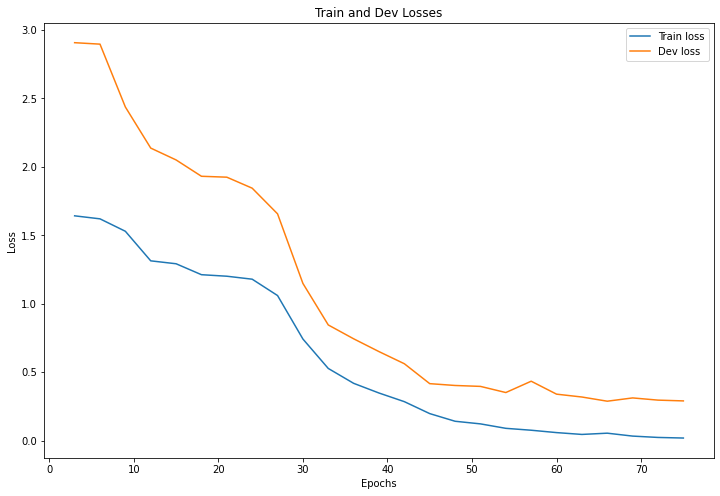

In [ ]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_train[0], ATIS_tot_losses_dev[0])

Intent loss plot 

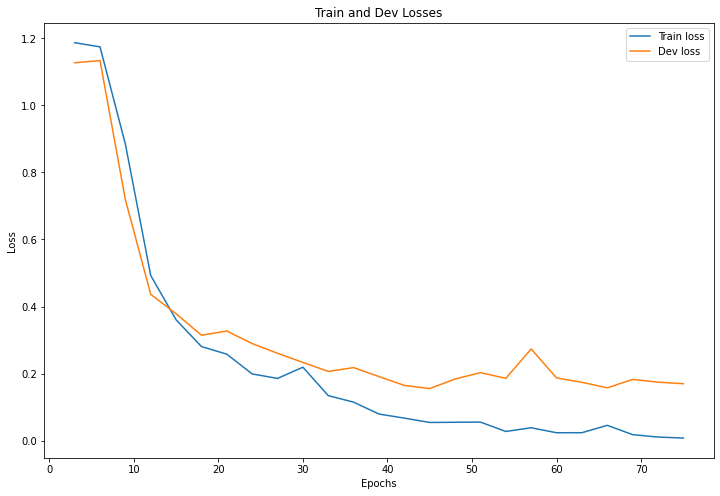

In [ ]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_intent_train[0], ATIS_tot_losses_intent_dev[0])

Slot loss plot

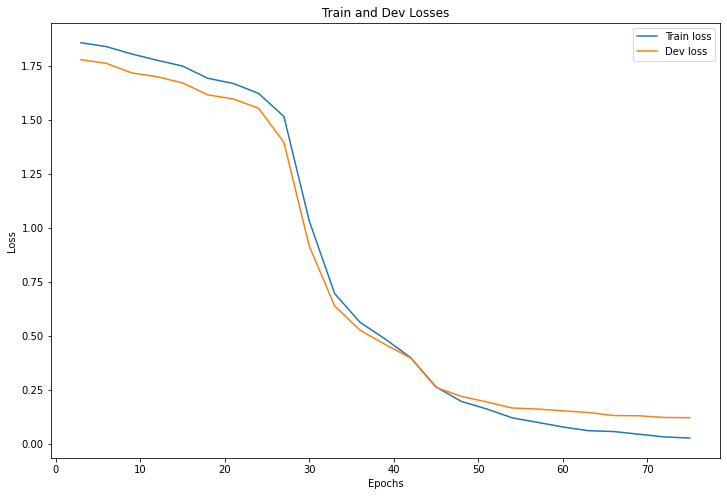

In [ ]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_slot_train[0], ATIS_tot_losses_slot_dev[0])

##Train on SNIPS 

In [ ]:
runs = 1
slot_f1s, intent_acc = [], []
SNIPS_tot_losses_train, SNIPS_tot_losses_dev = [], []
SNIPS_tot_losses_intent_train, SNIPS_tot_losses_intent_dev = [], []
SNIPS_tot_losses_slot_train, SNIPS_tot_losses_slot_dev = [], []
SNIPS_tot_sampled_epochs = []
SNIPS_tot_intent_test = []
SNIPS_tot_results_test = []
 
for x in tqdm(range(0, runs)):
    
    SNIPS_model_bert = Bert_model(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
    SNIPS_optimizer_bert = optim.Adam(SNIPS_model_bert.parameters(), lr=lr) #take default parameters, just modify lr
    
    results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array = train_adv(
        train_loader = SNIPS_train_loader, 
        test_loader = SNIPS_test_loader, 
        dev_loader = SNIPS_dev_loader, 
        model = SNIPS_model_bert, 
        criterion_slots = criterion_slots,
        criterion_intents = criterion_intents,
        optimizer = SNIPS_optimizer_bert,
        lang = SNIPS_lang,
        patience=3)
    
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
    SNIPS_tot_losses_train.append(losses_train)
    SNIPS_tot_losses_dev.append(losses_dev)
    SNIPS_tot_losses_intent_train.append(loss_intent_train)
    SNIPS_tot_losses_intent_dev.append(loss_intent_dev_array)
    SNIPS_tot_losses_slot_train.append(loss_slot_train)
    SNIPS_tot_losses_slot_dev.append(loss_slot_dev_array) 
    SNIPS_tot_sampled_epochs.append(sampled_epochs)
    SNIPS_tot_intent_test.append(intent_test)
    SNIPS_tot_results_test.append(results_test)
 
slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('\nSlot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/199 [00:00<?, ?it/s]

f1:  0.3600205286117526
accuracy:  0.9527777777777777
f1:  0.7385508776560644
accuracy:  0.9743055555555555
f1:  0.8285096023803084
accuracy:  0.9791666666666666
f1:  0.8387009836949197
accuracy:  0.9777777777777777
f1:  0.8541186049667526
accuracy:  0.9798611111111111
f1:  0.8634396971335857
accuracy:  0.98125
f1:  0.8535271943995693
accuracy:  0.9826388888888888
f1:  0.8427505330490405
accuracy:  0.9736111111111111
f1:  0.8673524634542502
accuracy:  0.9791666666666666
f1:  0.8664337543671056
accuracy:  0.9840277777777777

Slot F1:  0.847130242825607
Intent Accuracy: 0.9642857142857143

Slot F1 0.847 +- 0.0
Intent Acc 0.964 +- 0.0


###Intent classification analysis 

In [ ]:
x = SNIPS_tot_intent_test[0]
x.pop('accuracy')

KeyError: ignored

Macro average and weighted average

In [ ]:
avg = {'weighted avg': x['weighted avg'], 'macro avg' :  x['macro avg']}
x.pop('macro avg')
x.pop('weighted avg')
table = pd.DataFrame.from_dict(avg).transpose()
table.round(decimals=3)

,precision,recall,f1-score,support
weighted avg,0.965,0.964,0.964,700.0
macro avg,0.964,0.967,0.964,700.0


classified intent labels (based on F1-score):

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()
table.round(decimals=3)

,precision,recall,f1-score,support
RateBook,1.000,1.000,1.000,80.0
AddToPlaylist,0.992,1.000,0.996,124.0
GetWeather,0.990,0.990,0.990,104.0
BookRestaurant,0.979,1.000,0.989,92.0
SearchScreeningEvent,0.980,0.907,0.942,107.0
PlayMusic,0.887,1.000,0.940,86.0
SearchCreativeWork,0.921,0.869,0.894,107.0


###Slot filling analysis

In [ ]:
x = SNIPS_tot_results_test[0]

15 best classified slots

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:15]
table.round(decimals=3)

,p,r,f,s
best_rating,1.000,1.000,1.000,43.0
location_name,1.000,1.000,1.000,24.0
object_location_type,1.000,1.000,1.000,22.0
rating_unit,1.000,1.000,1.000,40.0
rating_value,0.988,1.000,0.994,80.0
restaurant_type,1.000,0.985,0.992,65.0
playlist_owner,0.986,0.986,0.986,70.0
condition_temperature,1.000,0.957,0.978,23.0
party_size_number,0.943,1.000,0.971,50.0
current_location,0.933,1.000,0.966,14.0


15 worst classified slot labels

In [ ]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:15]
table.round(decimals=3)

,p,r,f,s
album,0.111,0.300,0.162,10.0
track,0.143,0.222,0.174,9.0
served_dish,0.286,0.167,0.211,12.0
artist,0.609,0.393,0.477,107.0
city,0.742,0.383,0.505,60.0
entity_name,0.453,0.879,0.598,33.0
poi,0.500,0.750,0.600,8.0
restaurant_name,0.643,0.600,0.621,15.0
movie_name,0.674,0.617,0.644,47.0
genre,0.500,1.000,0.667,5.0


###Losses Plots

Total loss plot 

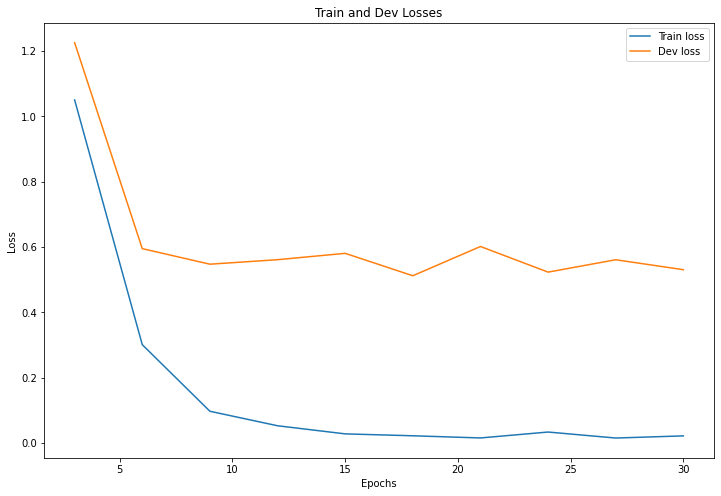

In [ ]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_train[0], SNIPS_tot_losses_dev[0])

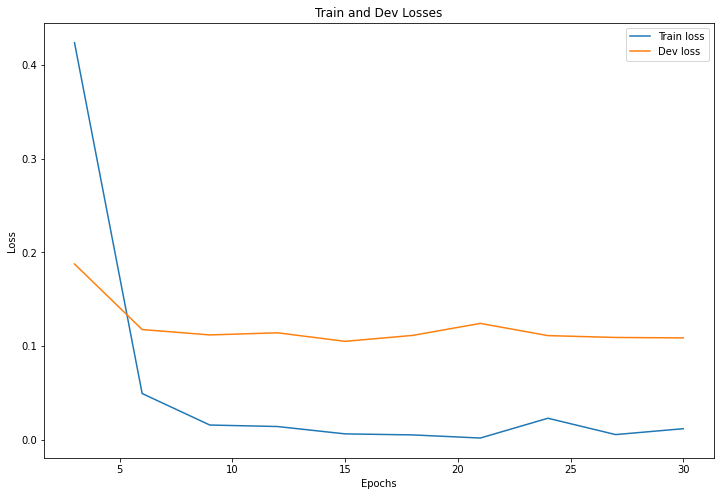

In [ ]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_intent_train[0], SNIPS_tot_losses_intent_dev[0])

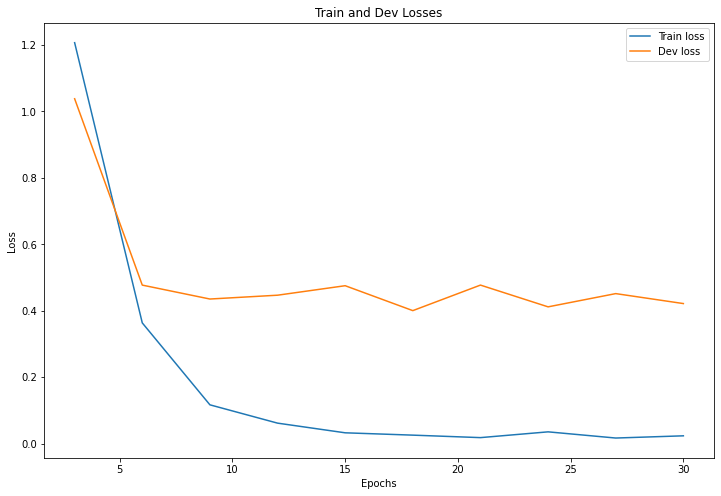

In [ ]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_slot_train[0], SNIPS_tot_losses_slot_dev[0])